# 0.0 IMPORTS

In [1]:
import math
import inflection
import warnings
import datetime
import matplotlib.gridspec

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

from IPython.core.display import HTML
from IPython.display      import Image
from datetime             import timedelta
from scipy                import stats as ss
from tabulate             import tabulate

warnings.filterwarnings('ignore')

## 0.1 HELPER FUNCTIONS

In [2]:
def cramer_v(x,y):
    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min (kcorr - 1, rcorr - 1)))
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 LOADING DATA

In [4]:
df_sales_raw = pd.read_csv ('data/train.csv',low_memory = False)
df_store_raw = pd.read_csv ('data/store.csv',low_memory = False)

df_raw = pd.merge(df_sales_raw,df_store_raw,how='left',on='Store')

# 1.0. DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 RENAME COLUMNS

In [6]:
cols_old = df_raw.columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))
df1.columns = cols_new

## 1.2 DATA DIMENSIONS

In [7]:
print("Number of Rows {}".format(df1.shape[0]))
print("Number of Columns {}".format(df1.shape[1]))

Number of Rows 1017209
Number of Columns 18


## 1.3 DATA TYPES

In [8]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 CHECK NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 FILLOUT NA

In [10]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x ['competition_open_since_month'], axis=1)

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x ['competition_open_since_year'], axis=1)

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x ['promo2_since_week'], axis=1)

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x ['promo2_since_year'], axis=1)

month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
df1['promo_interval'].fillna(0,inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

## 1.6 CHANGE TYPES

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

## 1.7 Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Statistical

In [14]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenando
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']
m

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

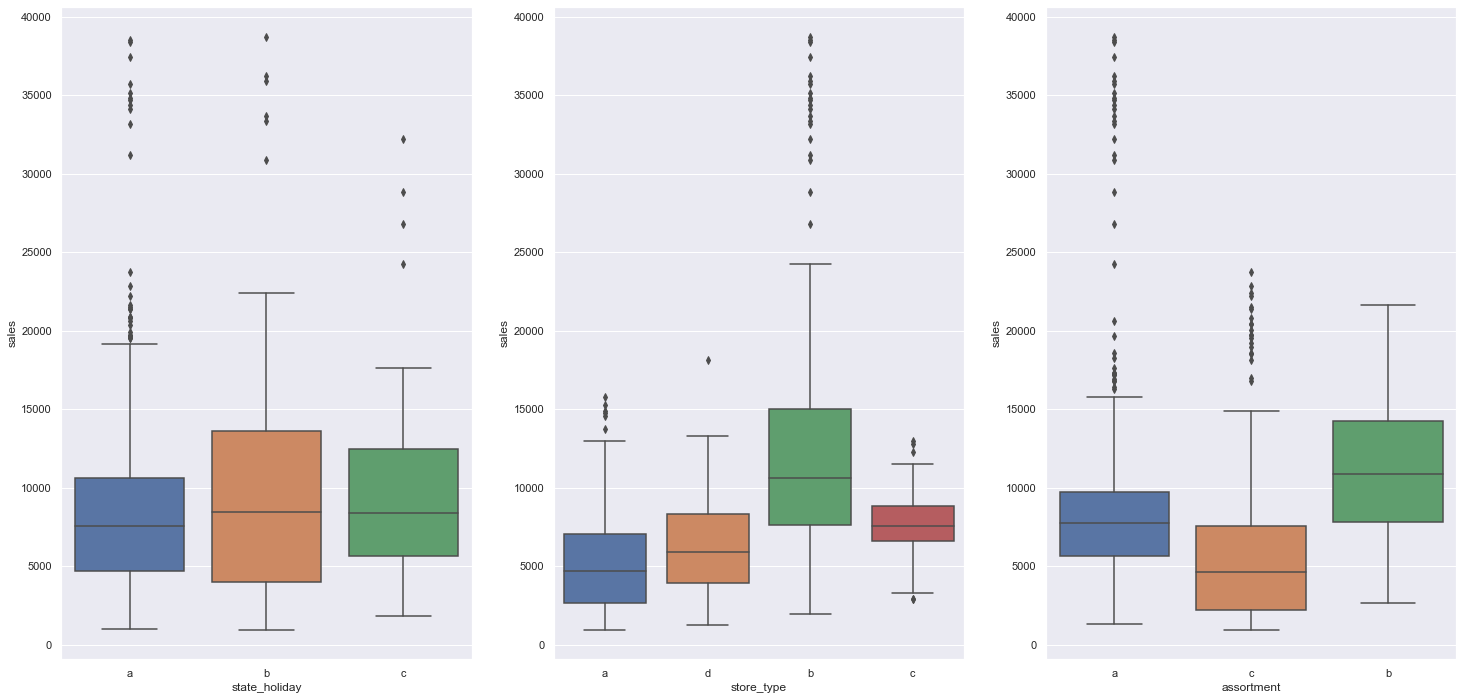

In [16]:
aux = df1 [(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux)
plt.subplot (1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux)
plt.subplot (1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux)

# 2.0 Passo 2 - FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

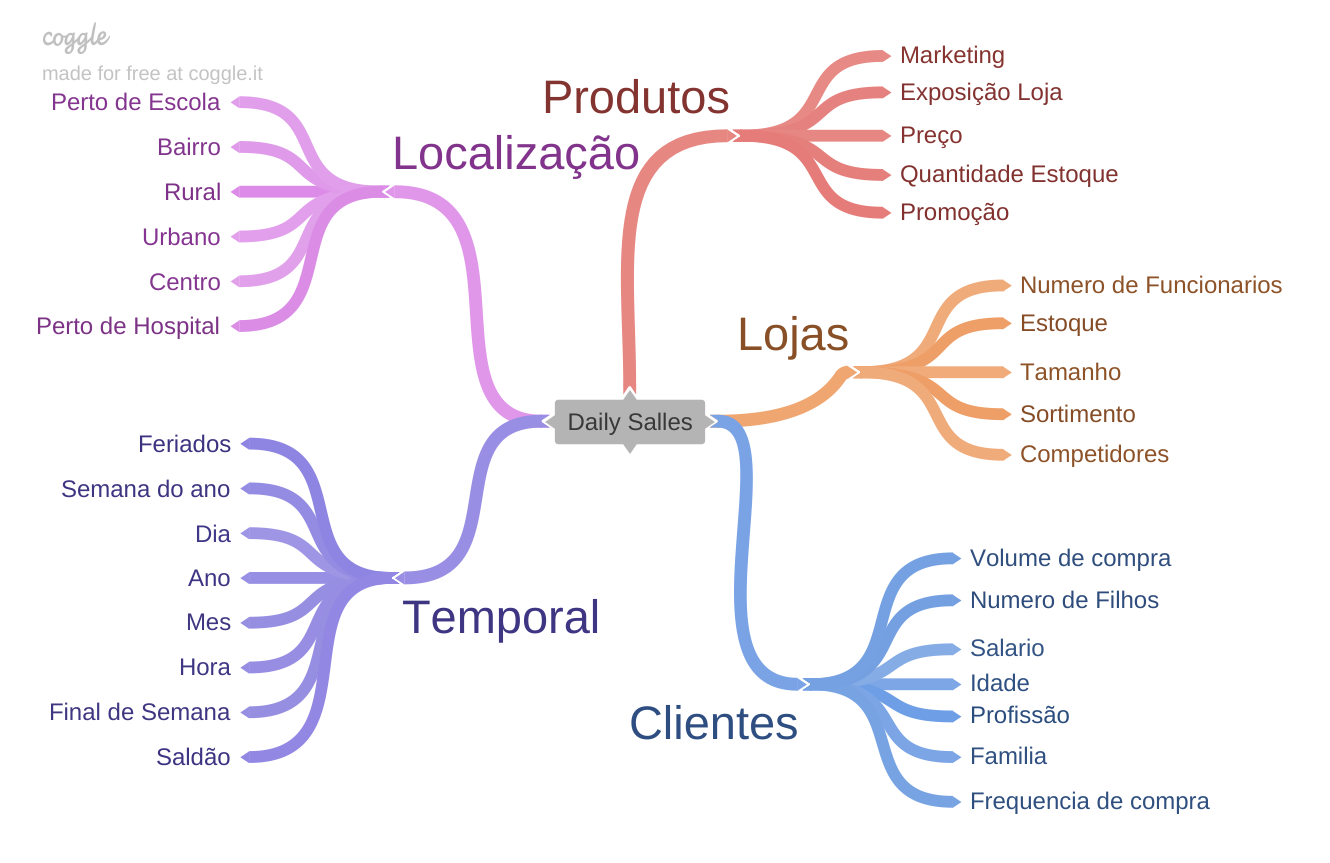

In [18]:
Image('img/Daily__Salles.png')

## 2.1 MAPA MENTAL DE HIPOTESES

### 2.1.1 HIPOTESES DA LOJA
**1.** Lojas com maior quadro de funcionarios deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores mais proximos deveriam vender mais

**6.** Lojas com competidores à mais tempo deveriam vender mais

### 2.1.2 HIPOTESES DE PRODUTOS

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expoem mais os produtos nas vitrines deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas que tem promoções ativas por mais tempo, deveriam vender mais

**5.** Lojas com promoções mais agressivas deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas, deveriam vender mais



### 2.1.3 HIPOTESES DE TEMPO

**1.** Lojas abertas durante o Natal, deveriam vender mais

**2.** Lojas deveriam vender mais ao longo do ano

**3.** Lojas deveriam vender mais no segundo semetre do ano

**4.** Lojas deveriam vender mais depois do dia 10

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2 LISTA DE HIPOTESES 

In [19]:
#1. Lojas com maior sortimento deveriam vender mais
#2. Lojas com competidores mais proximos deveriam vender mais
#3. Lojas com competidores à mais tempo deveriam vender mais
#4. Lojas que tem promoções ativas por mais tempo, deveriam vender mais
#5. Lojas com mais dias de promoção deveriam vender mais
#6. Lojas com mais promoções consecutivas, deveriam vender mais
#7. Lojas abertas durante o Natal, deveriam vender mais
#8. Lojas deveriam vender mais ao longo do ano
#9. Lojas deveriam vender mais no segundo semetre do ano
#10. Lojas deveriam vender mais depois do dia 10
#11. Lojas deveriam vender menos aos finais de semana
#12. Lojas deveriam vender menos durante os feriados escolares

## 2.3 FEATURE ENGINEERING

In [20]:
df2['year'] = df2['date'].dt.year

df2['month'] = df2['date'].dt.month

df2['day'] = df2['date'].dt.day

df2['week_of_year'] = df2['date'].dt.weekofyear

df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)

df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1','%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

<ipython-input-20-20a7ff5f4784>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 PASSO 3 - FILTRAGEM DE VARIAVEIS

In [21]:
df3 =df2.copy()

## 3.1 Filtragem das linhas

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção de colunas

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 PASSO 04 - ANALISE EXPLORATORIA DE DADOS

In [24]:
df4 = df3.copy()

## 4.1 Analise univariada

### 4.1.1 Response Variable

C:\Users\lucas\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


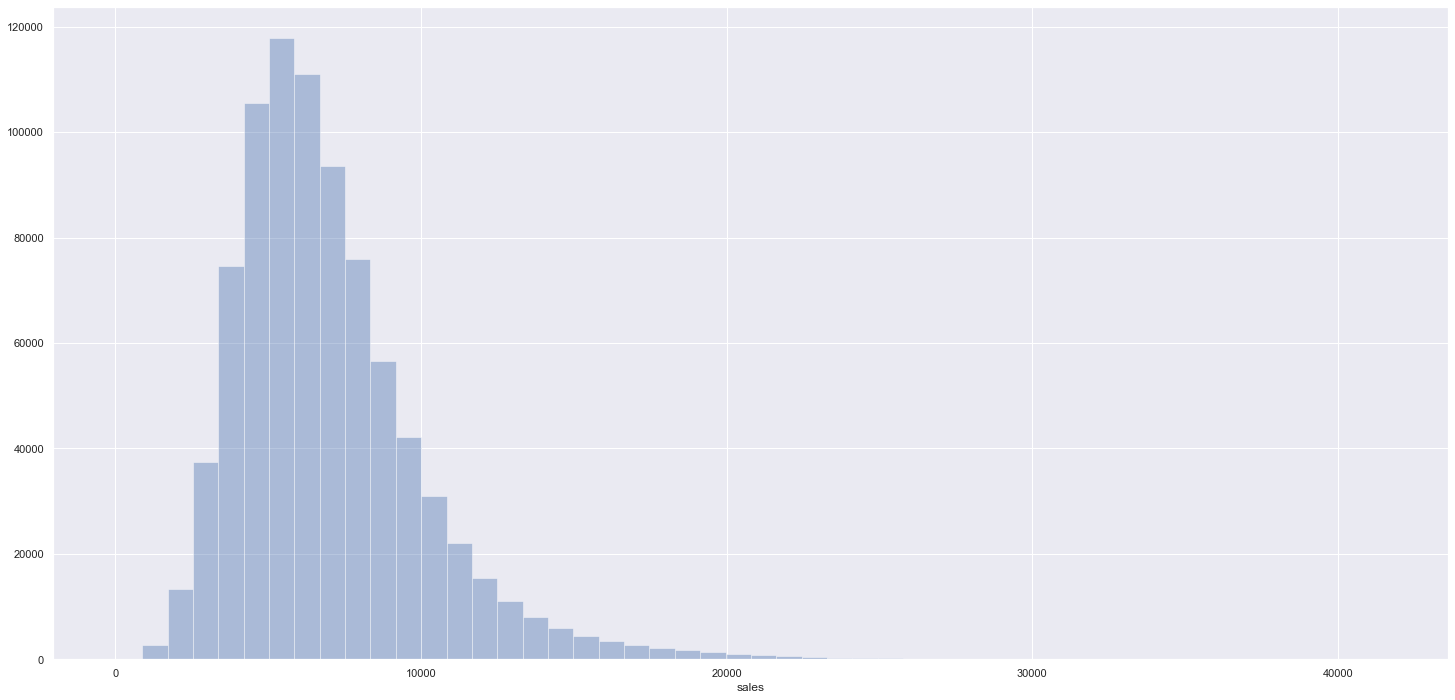

In [25]:
sns.distplot(df4['sales'], kde = False);

### 4.1.2 Numerical Variable

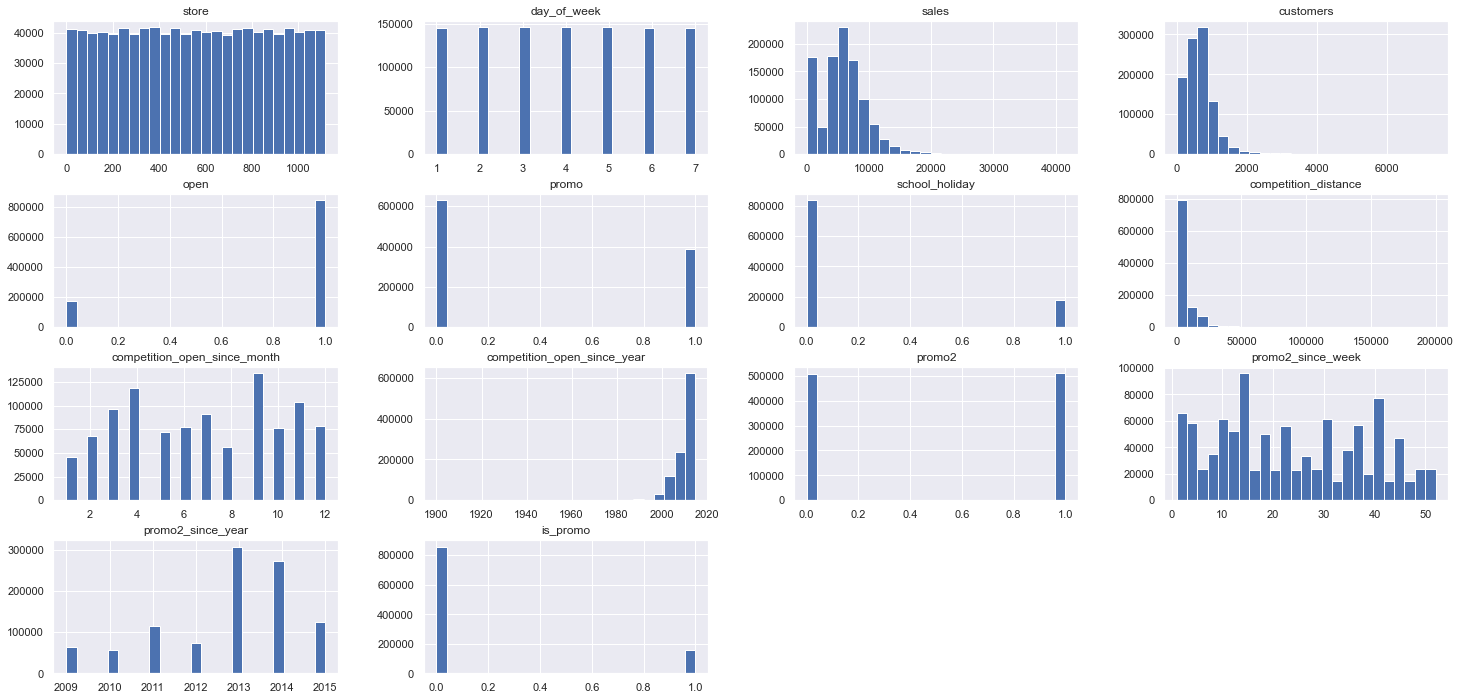

In [26]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [27]:
cat_attributes.columns

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'month_map'],
      dtype='object')

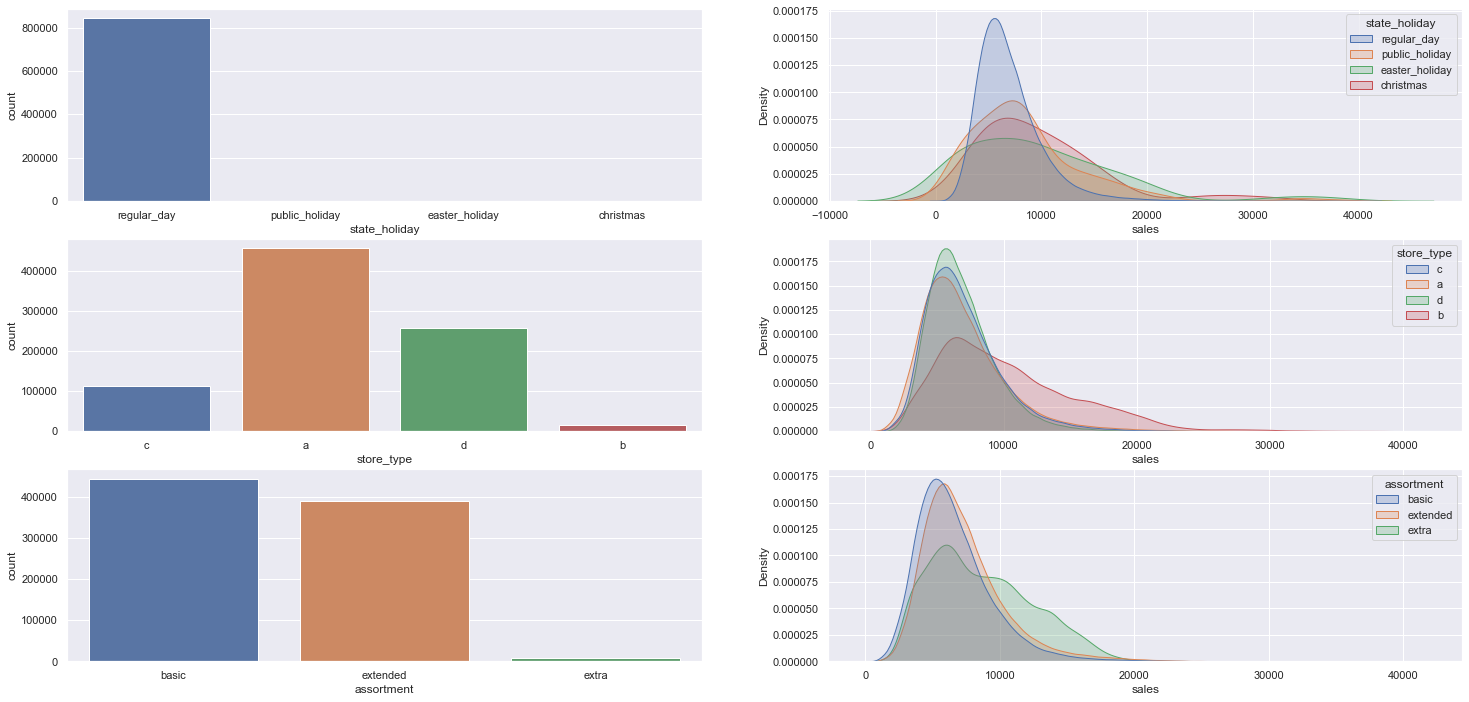

In [28]:
# State_holiday foi filtrado, pois existem mais dias regulares do que feriados.
a = df4[df4['state_holiday'] != 'regular day']

plt.subplot( 3, 2, 1)
sns.countplot ( x='state_holiday', data=a);

plt.subplot( 3, 2, 2)
sns.kdeplot(data=a, x = 'sales',hue='state_holiday',fill=True,common_norm=False);

plt.subplot( 3, 2, 3)
sns.countplot ( x='store_type', data=df4);

plt.subplot( 3, 2, 4)
sns.kdeplot(data=df4, x = 'sales',hue='store_type',fill=True,common_norm=False);

plt.subplot( 3, 2, 5)
sns.countplot ( x='assortment', data=df4);

plt.subplot( 3, 2, 6)
sns.kdeplot(data=df4, x = 'sales',hue='assortment',fill=True,common_norm=False);

## 4.2 Analise Bivariada

### H1 Lojas com maior sortimento deveriam vender mais
**Falsa** Lojas com maior sortment, vendem menos

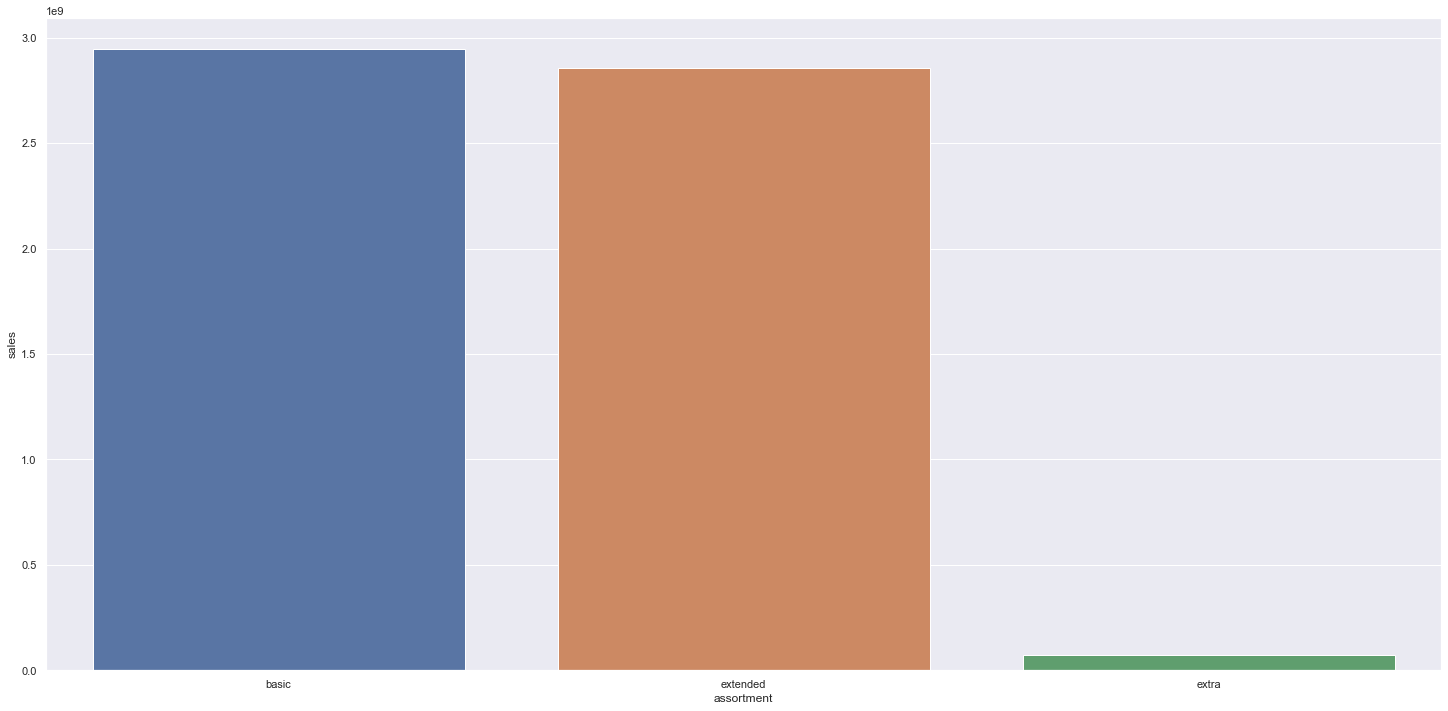

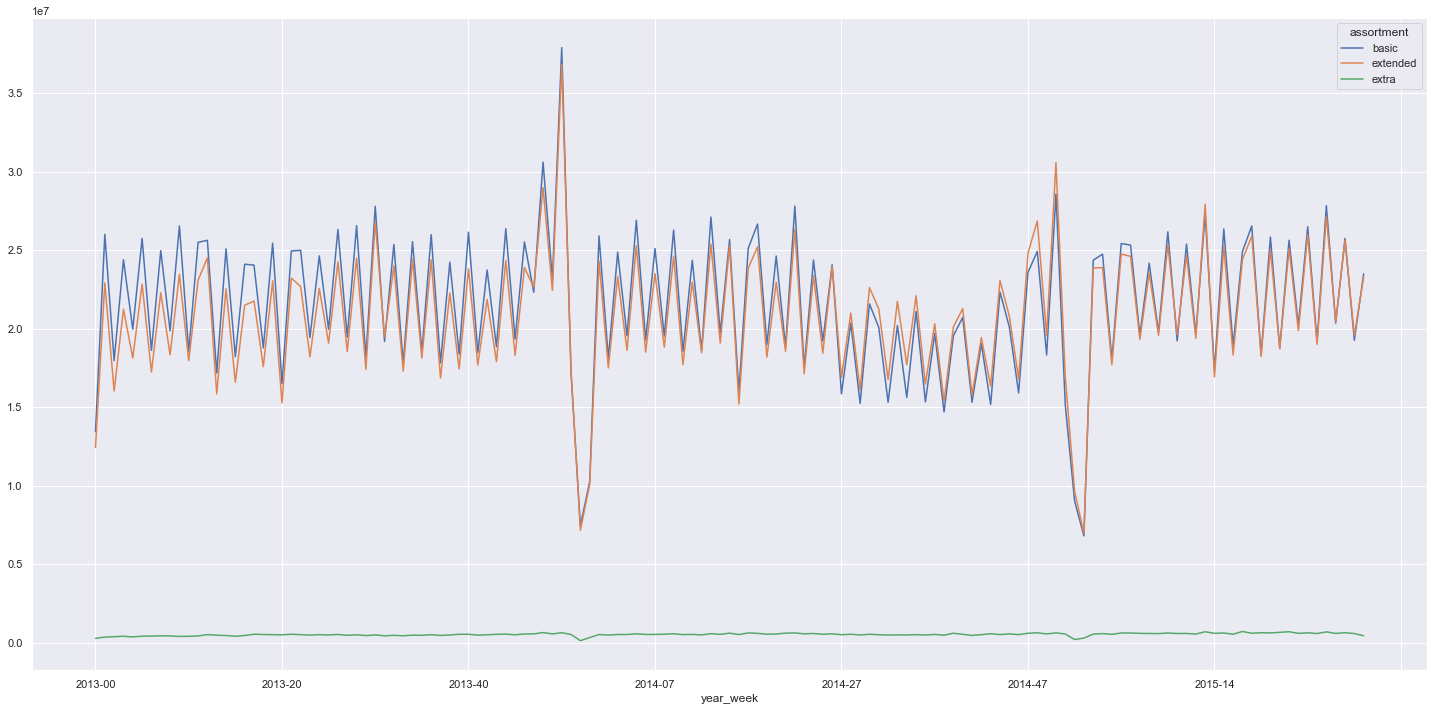

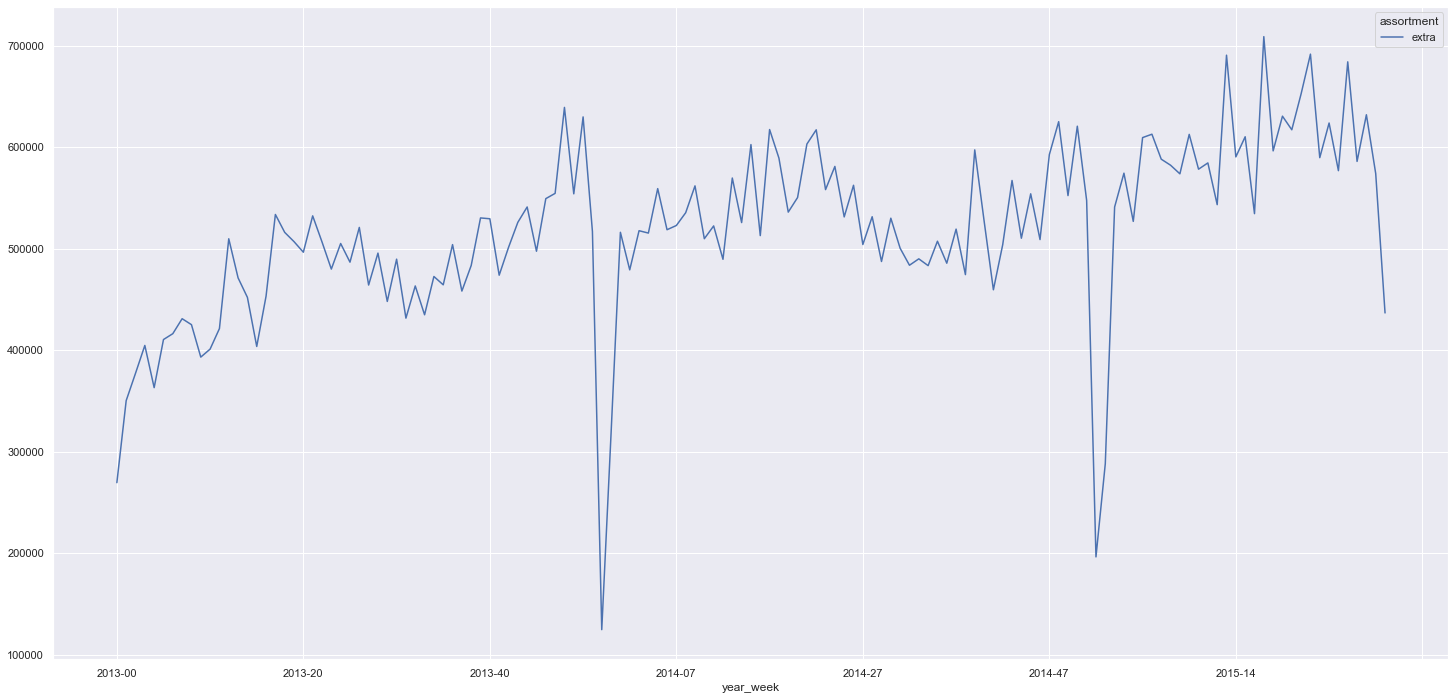

In [29]:
# Devido a discrepancia de valores entre os assortments, isolar o assortment extra para ver seu comportamento 
#ao longo do tempo 

aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot( x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot();

### H2 Lojas com competidores mais proximos deveriam vender mais
**Falsa** Lojas com competidores proximos vendem mais

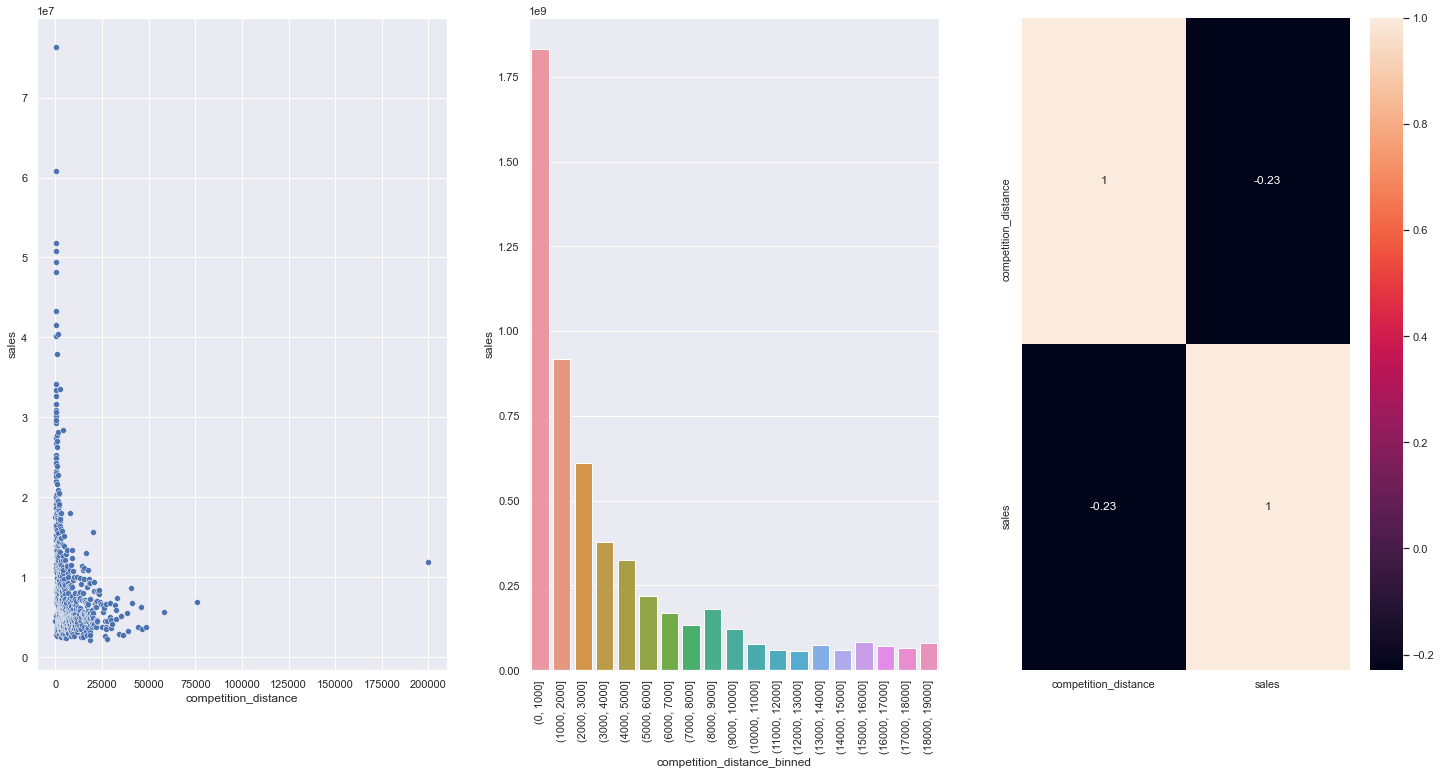

In [30]:
# Grafico separado em intervalos, pois os dados originais são divididos em muito dados distintos.

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure()
plt.subplot( 1, 3, 1)
sns.scatterplot( x='competition_distance', y= 'sales', data = aux1);

plt.subplot( 1, 3, 2)
bins =  list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins= bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90)

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H3 Lojas com competidores à mais tempo deveriam vender mais
**Falsa** Lojas com competidores a mais tempo, vendem menos

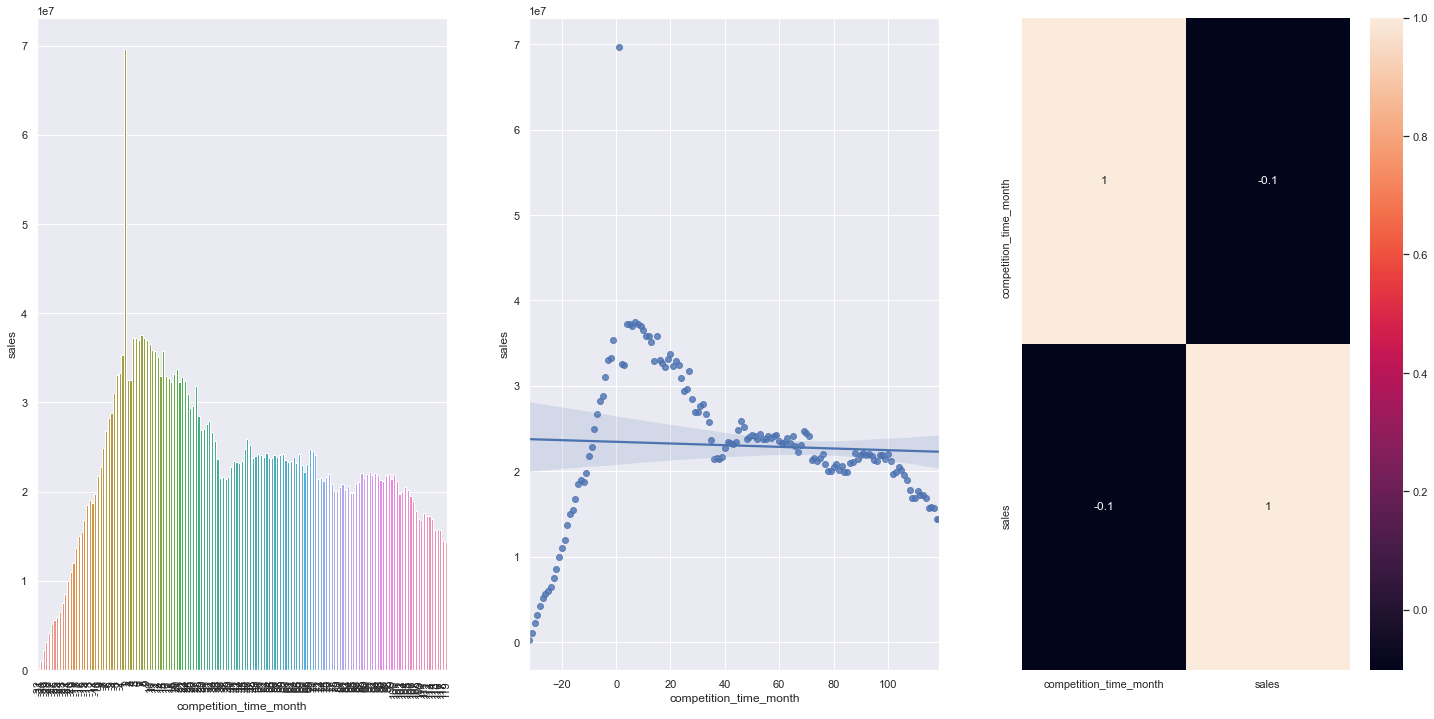

In [31]:
# Devido a granularidade dos dados, foi feito um filtro dos dados.

plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y= 'sales', data= aux2);
plt.xticks(rotation = 90)

plt.subplot( 1, 3, 2)
sns.regplot(x='competition_time_month',y= 'sales', data = aux2);

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'),annot = True);

### H4 Lojas que tem promoções ativas por mais tempo, deveriam vender mais
**Falsa** Lojas com promoções ativas por mais tempo, vendem regularmente e depois decaem

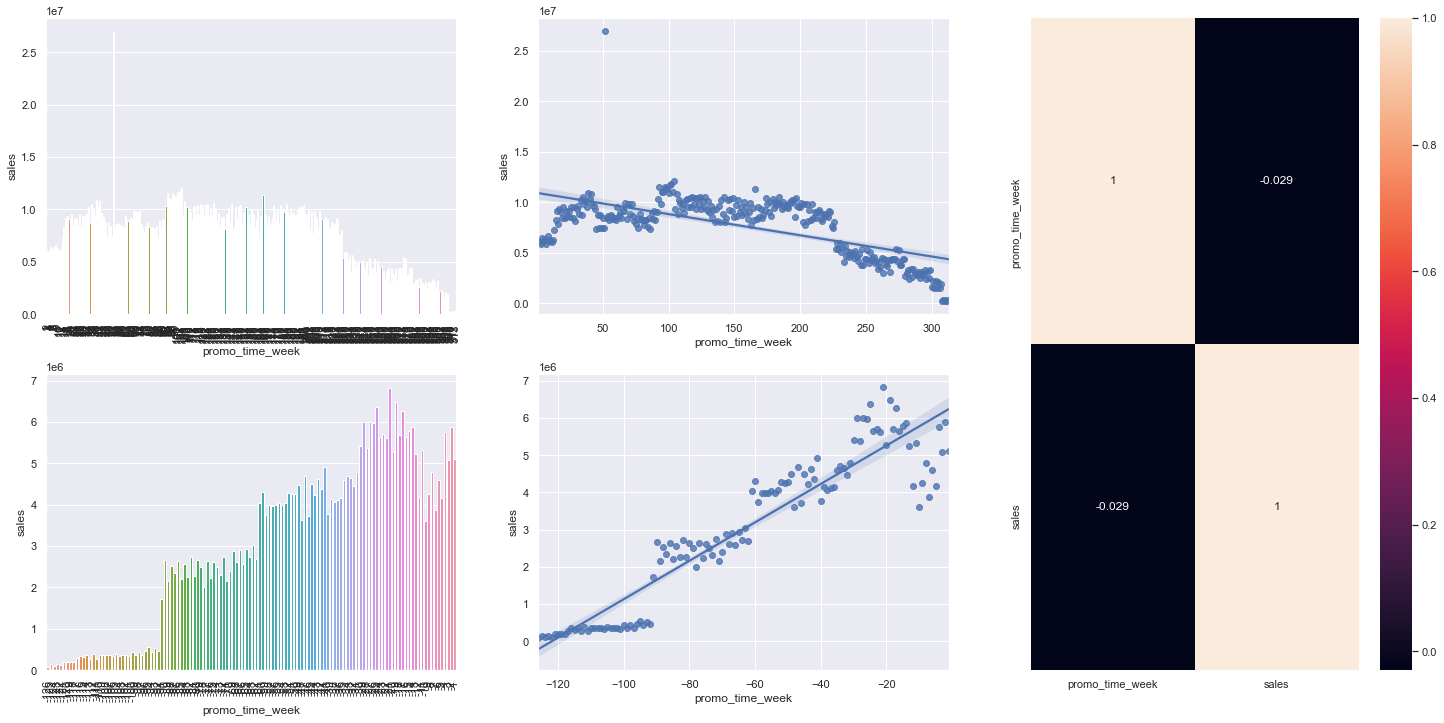

In [32]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promoção extendida
sns.barplot(x = 'promo_time_week', y= 'sales', data=aux2);
plt.xticks(rotation = 90)

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y= 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promoção regular
sns.barplot(x='promo_time_week',y='sales', data = aux3);
plt.xticks(rotation = 90)

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y= 'sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H5 Lojas com mais promoções consecutivas, deveriam vender mais
**Falsa** Lojas com mais promoções consecutivas vendem menos

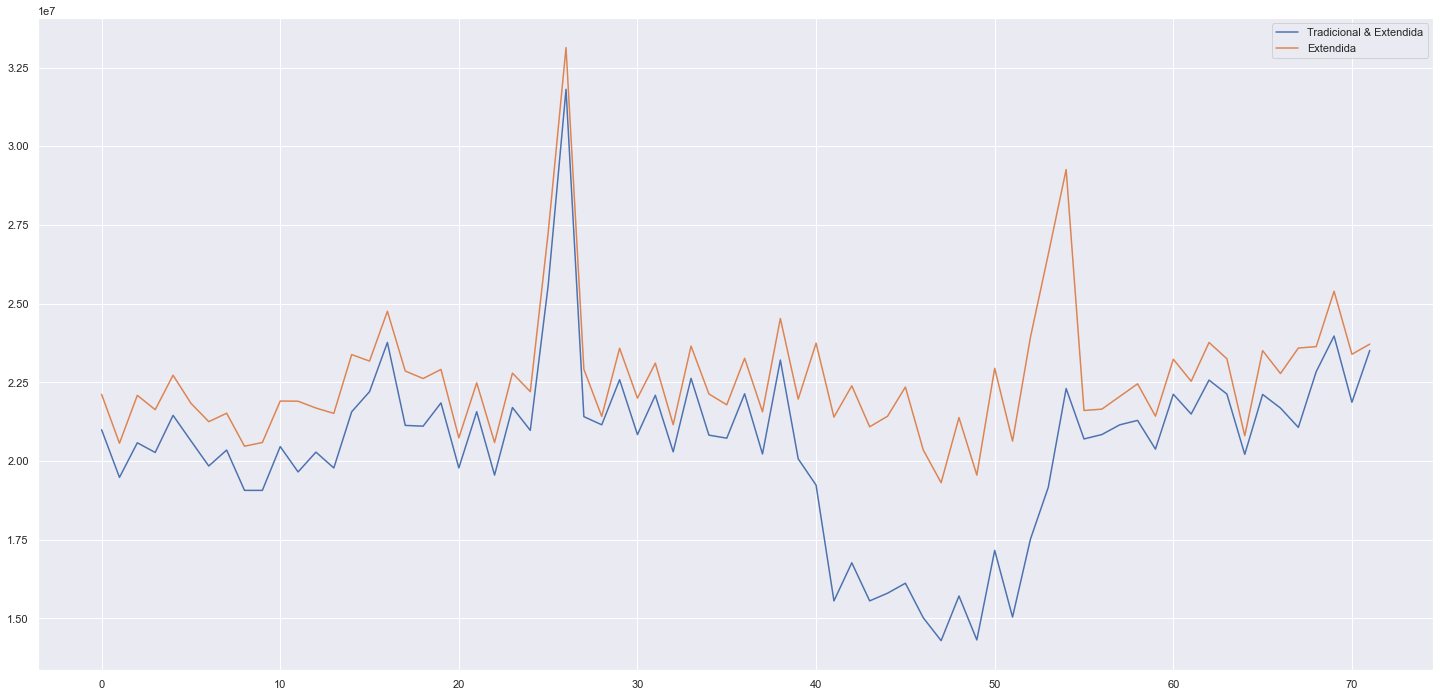

In [33]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida','Extendida']);

### H6 Lojas abertas durante o Natal, deveriam vender mais
**Falsa** Lojas abertas durante o Natal, vendem menos.

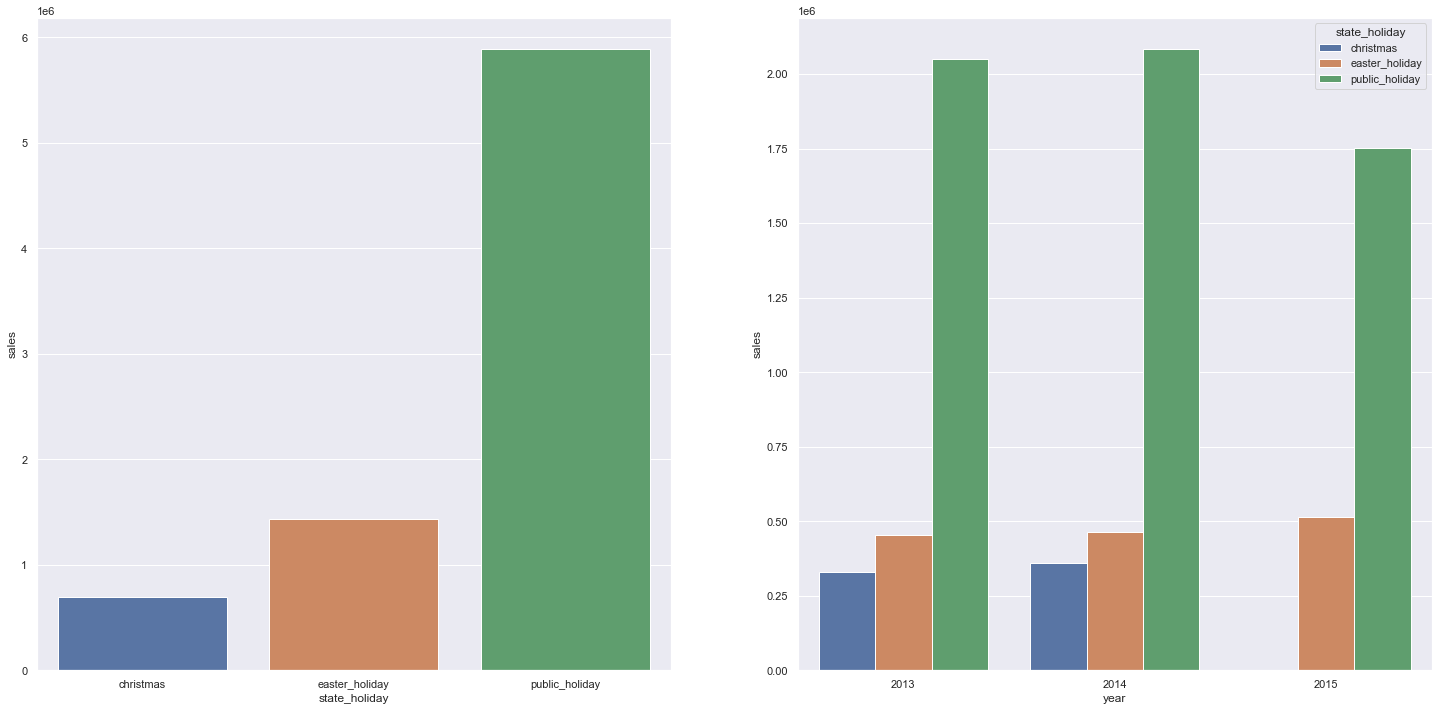

In [34]:
#Devido a existir muitos dias regulares a mais que feriados, foi feito um filtro no dataset

aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y= 'sales', data=aux1);

plt.subplot( 1, 2, 2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y= 'sales', hue = 'state_holiday', data = aux2);

### H7 Lojas deveriam vender mais ao longo dos anos
**Falsa** Lojas vendem menos ao longo dos anos

<AxesSubplot:>

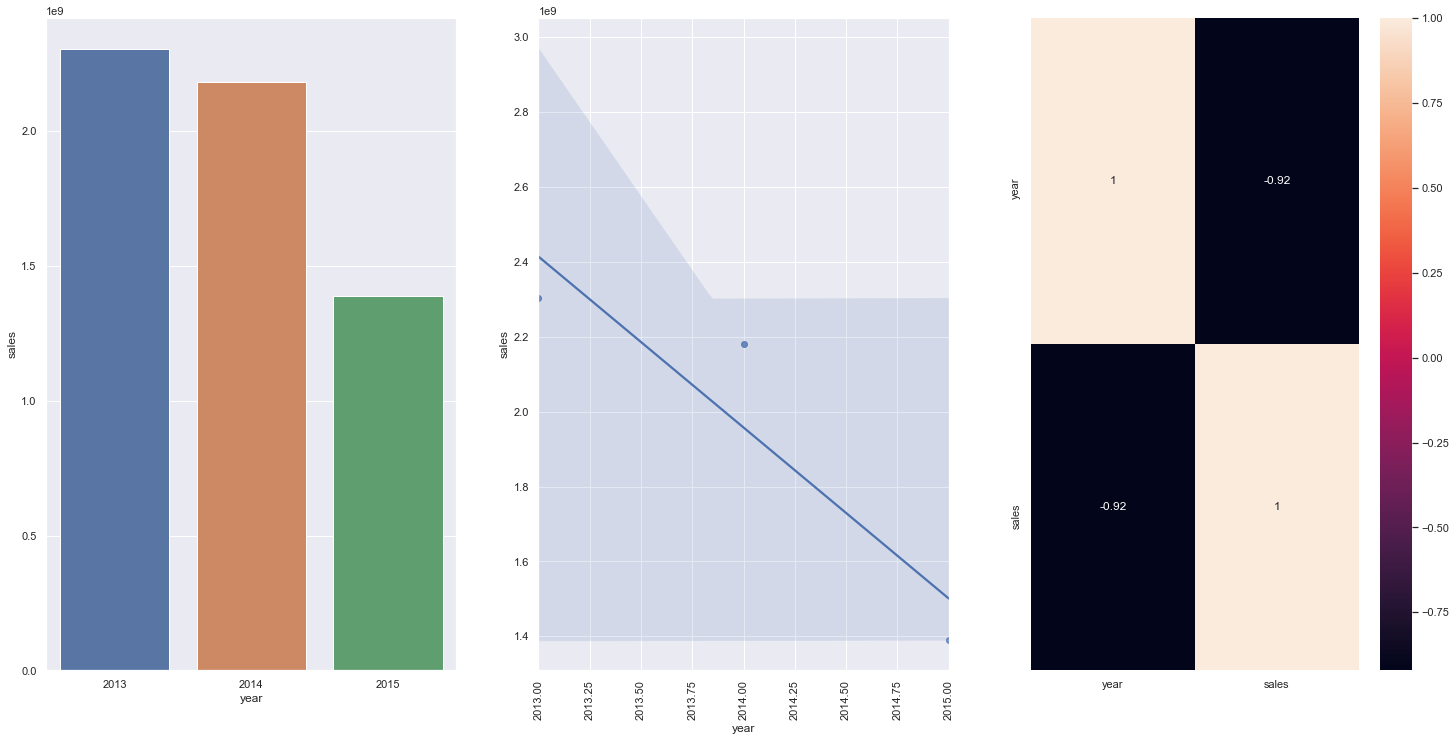

In [35]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y= 'sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year', y= 'sales', data = aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot= True)

### H8 Lojas deveriam vender mais no segundo semestre
**Falsa** Lojas vendem menos no segundo semestre

<AxesSubplot:>

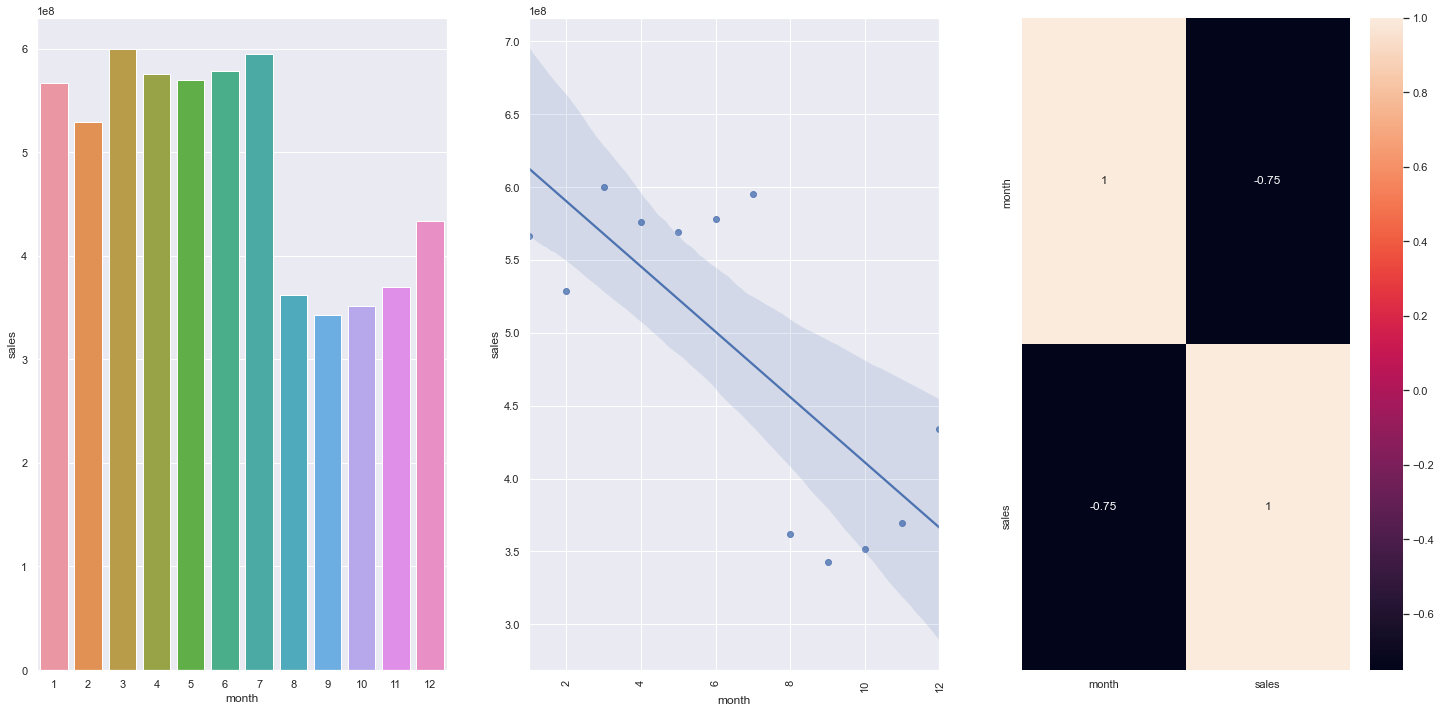

In [36]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y= 'sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y= 'sales', data = aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot= True)

### H9 Lojas deveriam vender mais depois do dia 10, de cada mês
**Verdadeira** Lojas vendem mais após o dia 10 de cada mês.

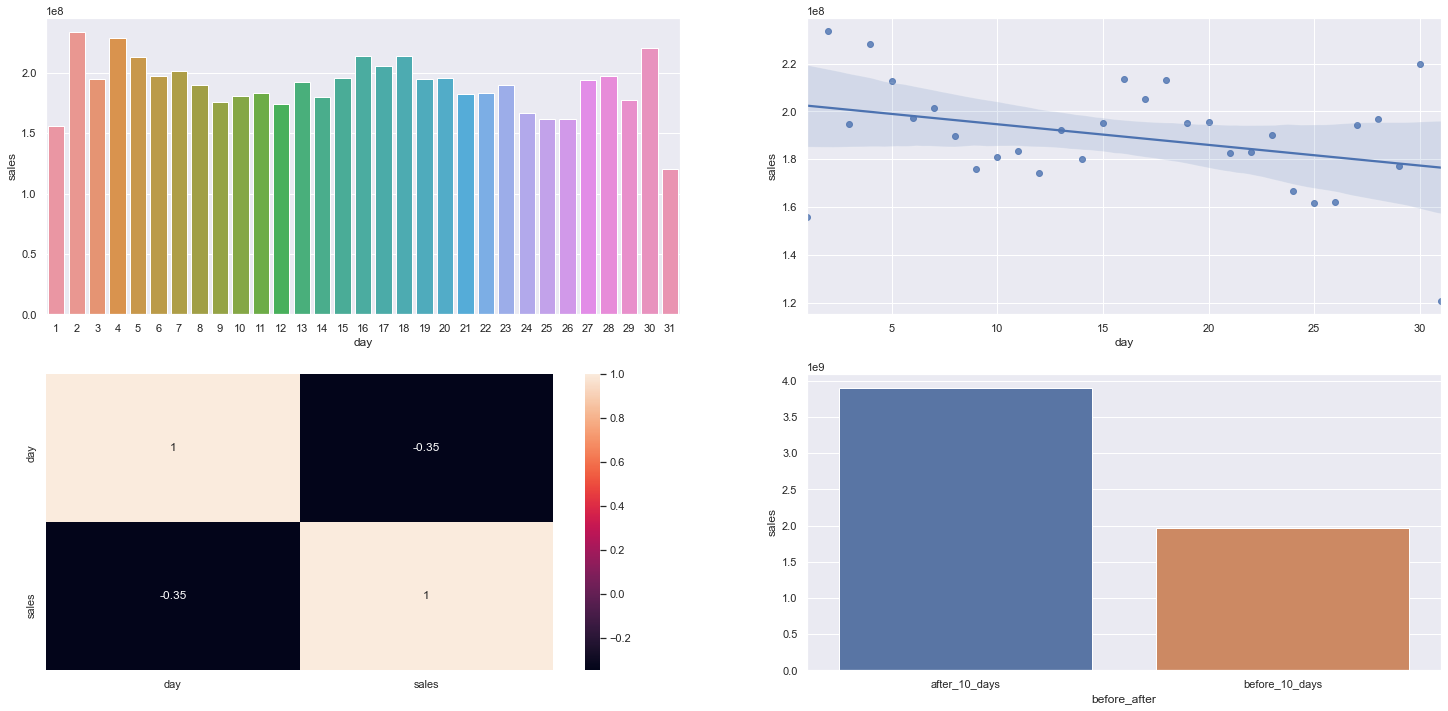

In [37]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data= aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'),annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data = aux2);

### H10 Lojas deveriam vender menos aos finais de semana
**Verdadeira** Lojas vendem menos aos finais de semana

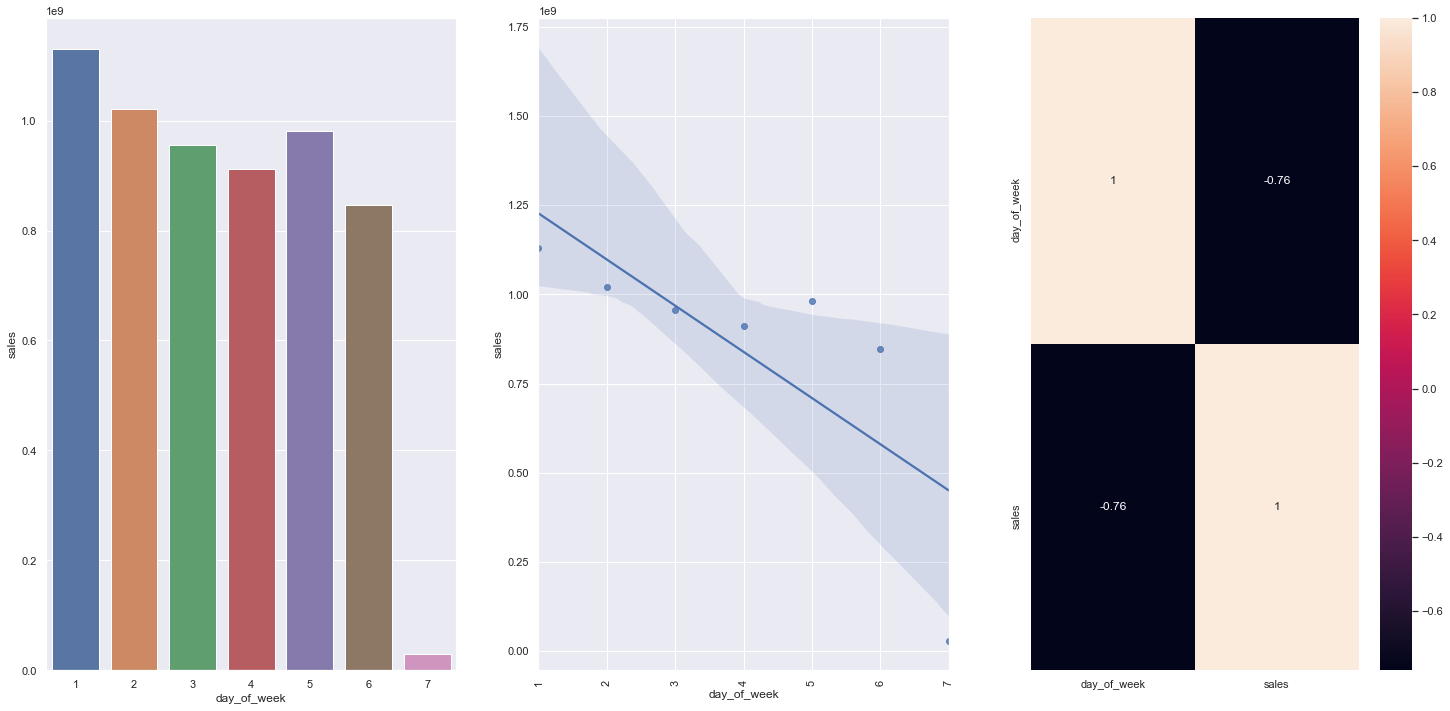

In [38]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y= 'sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y= 'sales', data = aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot= True);

### H11 Lojas deveriam vender menos durante os feriados escolares
**Verdadeira** Lojas vendem menos nos feriados escolares, exceto nos meses de julho e agosto.

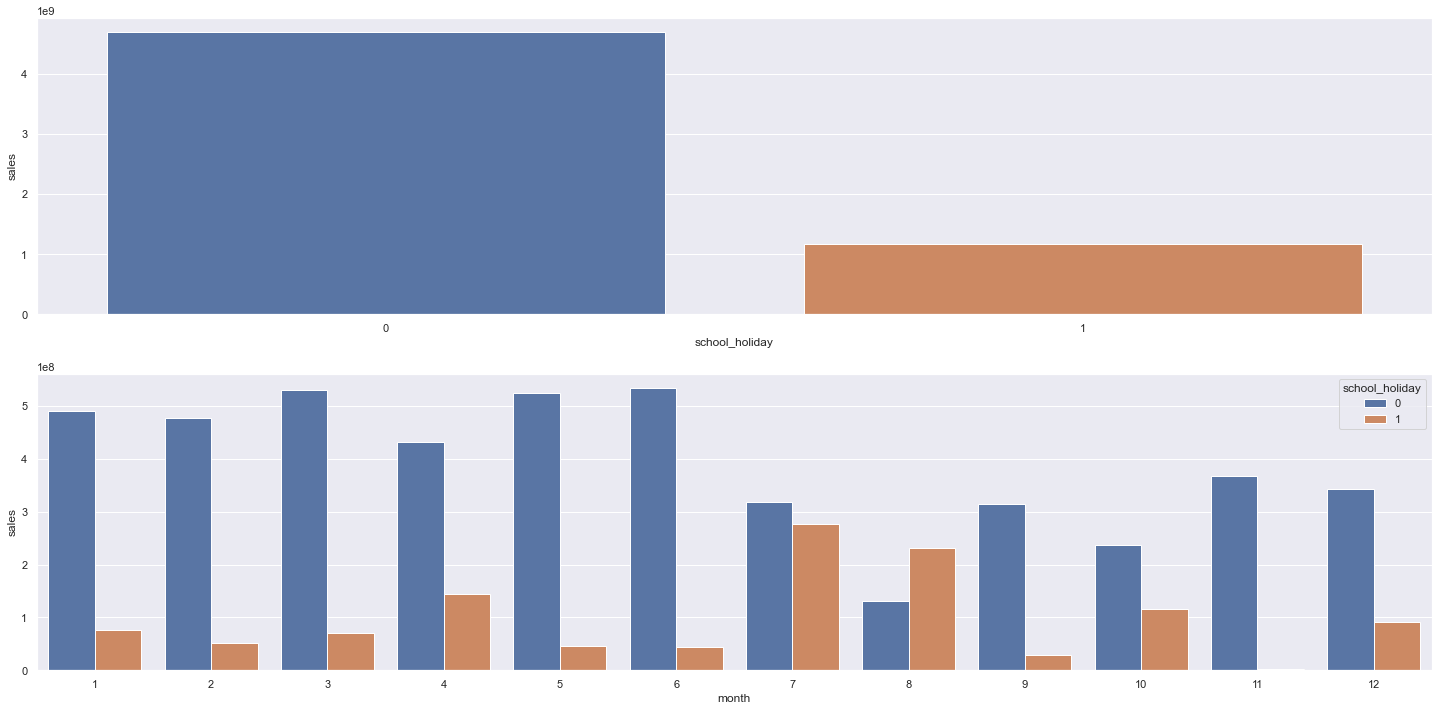

In [39]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux1);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2);

### 4.2.1 Resumo de Hipoteses

In [40]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Atributos Numericos

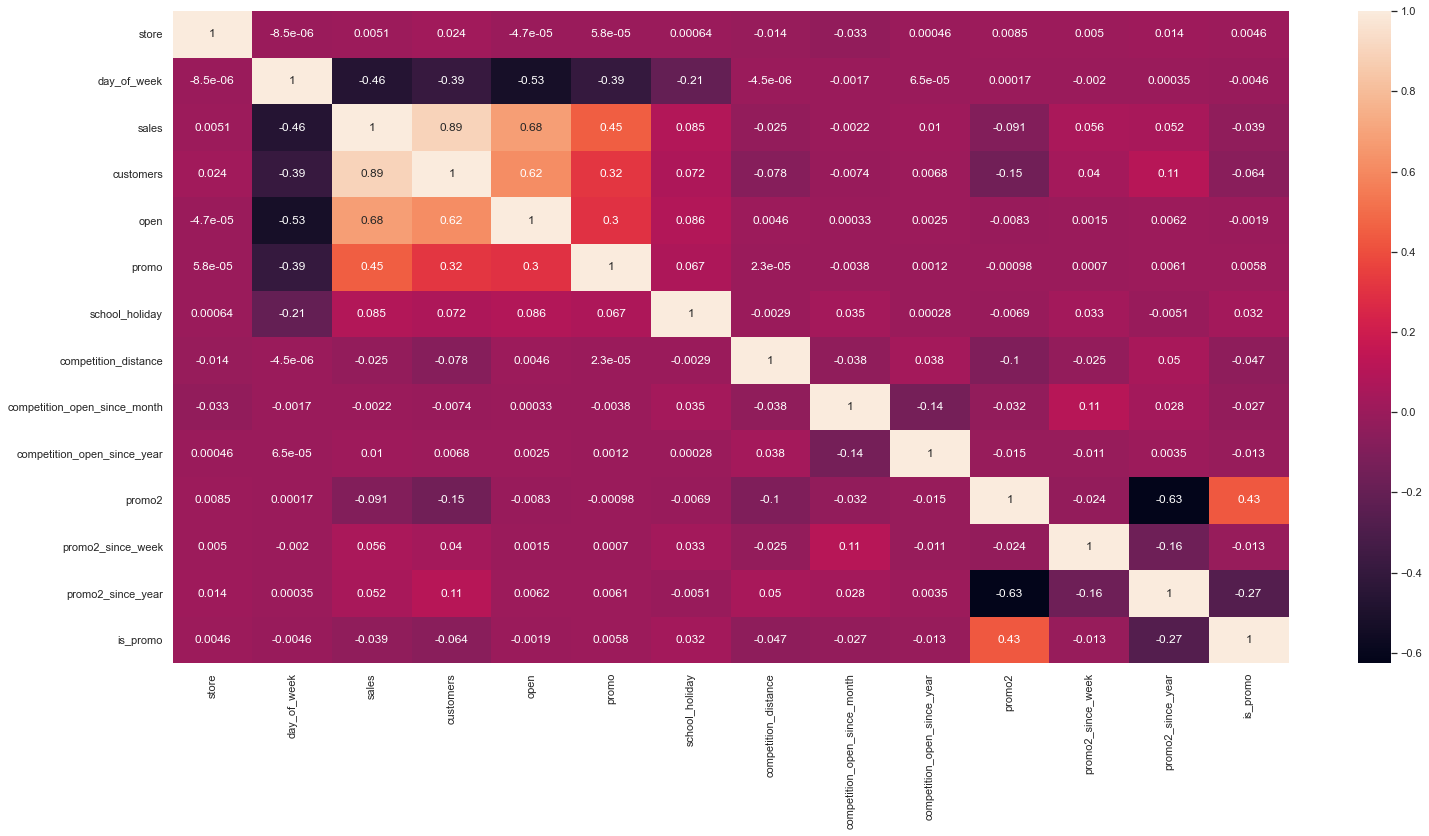

In [41]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot = True);

### 4.3.2 Atributos Categoricos

In [42]:
# Only categorical variable
a = df4.select_dtypes(include='object')

<AxesSubplot:>

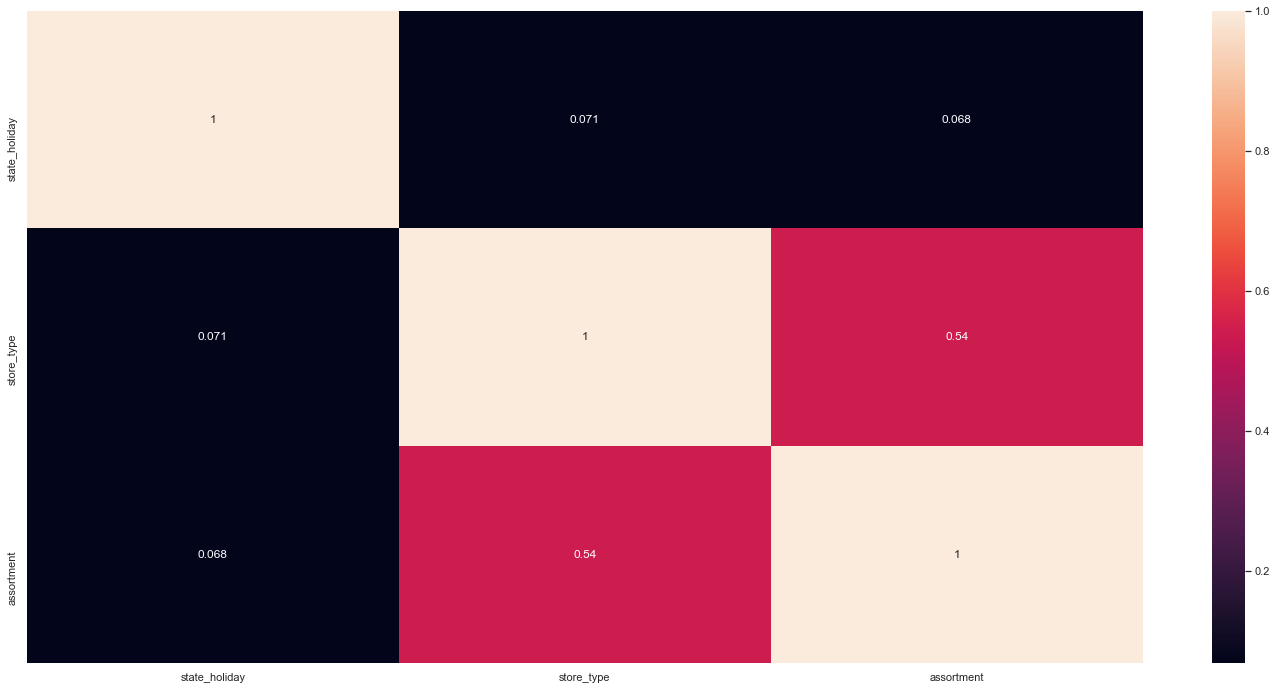

In [43]:
# Calculate cramer v
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday':[a1,a2,a3],
               'store_type':[a4,a5,a6],
               'assortment':[a7,a8,a9]})

d = d.set_index(d.columns)
sns.heatmap(d,annot=True)